<a id="section-1"></a>
#### Sales forcasting for Multiple Timeseries
#### 1. Introduction
On this project, I will use Walmart's sales data to create a forecasting model to predict future sales.

Understanding the fluctuating patterns of sales throughout the year is crucial for companies, as it enables them to avoid potential financial losses. Accurate sales predictions facilitate effective stock management, revenue calculation, and informed investment decisions. Furthermore, meeting predetermined sales targets at the onset of each season can positively influence stock prices and investor sentiment, while failing to reach these projections can have detrimental effects, particularly for major corporations like Walmart.

#### Table of Content

1. [Introduction](#section-1)
2. [Goal on this kernel](#section-2)
3. [Data Preparation](#section-3)
    * 3.1.[Import Library](#section-3)
    * 3.2.[Load Dataset](#section-32)
    * 3.3.[Overview about Walmart's Data](#section-33)    
4. [Exploratory Data](#section-4)
    * 4.1.[Check NULL or missing data](#section-4)
    * 4.2.[Check and handling missing timeseries](#section-42)
    * 4.3.[Check and handling Outliers](#section-43)    
    * 4.4.[Explore timeseries at Store and Dept level](#section-44)    
5. [Build Forecast Model](#section-5)
    * 5.1.[Feature Engineering](#section-51)
    * 5.2.[Build Forecast Model](#section-52)
    * 5.3.[Valid test and measure the error](#section-53)    
6. [Forecast Future Sales](#section-6)
    * 6.1.[Final Model](#section-6)
    * 6.2.[Submitted Forecast](#section-62)

<a id="section-2"></a>
#### 2. Goal on this kernel
To create forecasting model to predict future sales

<a id="section-3"></a>
#### 3. Data Preparation
#### 3.1 Import Library
In the initial phase, we need to import the necessary libraries for developing the forecasting model. In this analysis, we will utilize the **tidyverse** library to efficiently manage the data, the **ggplot2** library to generate insightful plots, and the **lightGbm** library to construct the forecasting model.

In [1]:
# Read Libraries
suppressPackageStartupMessages(library(tidyverse))
library(ggplot2)
library(lightgbm)

Loading required package: R6


Attaching package: ‘lightgbm’


The following object is masked from ‘package:dplyr’:

    slice




<a id="section-32"></a>
#### 3.2 Load Dataset
then we load the data using **read.csv**, and ensure the Date column is on date format with **as.Date()**. And check summaries of all the data using **str()**.

In [2]:
#Import data
train <-read.csv("/kaggle/input/walmart-sales-forecast/train.csv") 
test <-read.csv("/kaggle/input/walmart-sales-forecast/test.csv")
stores <-read.csv("/kaggle/input/walmart-sales-forecast/stores.csv")
features <-read.csv("/kaggle/input/walmart-sales-forecast/features.csv")

# convert date column to date type
train$Date <- as.Date(train$Date, "%Y-%m-%d")
test$Date <- as.Date(test$Date, "%Y-%m-%d")
features$Date <- as.Date(features$Date, "%Y-%m-%d")

str(train)
str(stores)
str(features)

'data.frame':	421570 obs. of  5 variables:
 $ Store       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Dept        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Date        : Date, format: "2010-02-05" "2010-02-12" ...
 $ Weekly_Sales: num  24924 46039 41596 19404 21828 ...
 $ IsHoliday   : logi  FALSE TRUE FALSE FALSE FALSE FALSE ...
'data.frame':	45 obs. of  3 variables:
 $ Store: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Type : chr  "A" "A" "B" "A" ...
 $ Size : int  151315 202307 37392 205863 34875 202505 70713 155078 125833 126512 ...
'data.frame':	8190 obs. of  12 variables:
 $ Store       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Date        : Date, format: "2010-02-05" "2010-02-12" ...
 $ Temperature : num  42.3 38.5 39.9 46.6 46.5 ...
 $ Fuel_Price  : num  2.57 2.55 2.51 2.56 2.62 ...
 $ MarkDown1   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown2   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown3   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown4   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown

<a id="section-33"></a>
#### 3.3 Overview about Walmart's Data
* Walmart has 45 stores. According to its sizes, store is categorized into 3 type ; A, B, and C
* We have sales data from 2010 to 2013
* We also have Temperature, Fuel_Price,Promotion, CPI, unemployment, and holiday data that we can explore and maybe we can used them as features to the model

<a id="section-4"></a>
#### 4. Exploratory Data
#### 4.1 Check NULL or missing data

Before further analysis, I'd like to check if our data contains of missing value. This to ensure the quality, reliability, and effectiveness of the data used to train machine learning models. By addressing issues like missing values, outliers, duplicates, inconsistencies, and irrelevant features, data cleansing helps create a clean and reliable dataset, which in turn leads to more accurate and reliable predictions from the machine learning model.

In [3]:
# create list store list of dataframe
data <- list(train,stores,features)

# Loop through each dataframe on list, if data type is numeric then print sum of na values, else print unique value
for (dataset in data) {
    for (col in colnames(dataset)) {
        if (is.Date(dataset[[col]]) || is.numeric(dataset[[col]])) {
            missing_values <- sum(is.na(dataset[[col]]))
            cat("missing_values for column", col, ":",missing_values,"\n")}
        else {
            unique_values <- unique(dataset[[col]])
            cat("Unique values for column", col,":",unique_values,"\n")}}}

missing_values for column Store : 0 
missing_values for column Dept : 0 
missing_values for column Date : 0 
missing_values for column Weekly_Sales : 0 
Unique values for column IsHoliday : FALSE TRUE 
missing_values for column Store : 0 
Unique values for column Type : A B C 
missing_values for column Size : 0 
missing_values for column Store : 0 
missing_values for column Date : 0 
missing_values for column Temperature : 0 
missing_values for column Fuel_Price : 0 
missing_values for column MarkDown1 : 4158 
missing_values for column MarkDown2 : 5269 
missing_values for column MarkDown3 : 4577 
missing_values for column MarkDown4 : 4726 
missing_values for column MarkDown5 : 4140 
missing_values for column CPI : 585 
missing_values for column Unemployment : 585 
Unique values for column IsHoliday : FALSE TRUE 


Quick glimpse above shows there are no missing value for numeric and categorical columns. 
We also need to check if our time series doesn't consist of missing date.

<a id="section-42"></a>
#### 4.2 Check and handling missing timeseries

In [4]:
# check current rows/dates in data train
current_n_rows_train <- nrow(train)

# complete gap or missing dates and fill gap Date with Weekly_Sales=0
train <- train %>%
  group_by(Store, Dept) %>%
  mutate(Date = as.Date(Date)) %>%
  complete(Date = seq.Date(min(Date), max(Date), by="week")) %>%
  mutate(Weekly_Sales = ifelse(is.na(Weekly_Sales),0, Weekly_Sales)) %>%
  ungroup()

# check rows after data train is completed
new_n_rows_train <- nrow(train)

# print if there are missing date in our dataset
if (new_n_rows_train - current_n_rows_train != 0) {
    cat("There are missing date in our timeseries, the date has been completed and fill the Weekly_Sales by 0")
}

There are missing date in our timeseries, the date has been completed and fill the Weekly_Sales by 0

After addressing the missing dates in the time series data on the previous R code, I utilized the **Complete()** function to append the missing dates and filled the corresponding Weekly_Sales values with 0 using the condition **ifelse(is.na(Weekly_Sales), 0, Weekly_Sales)**. To further analyze the Weekly_Sales distribution, I proceeded to create a boxplot for each department (Dept) to determine whether any negative values exist

<a id="section-43"></a>
#### 4.3 Check and handling Outliers

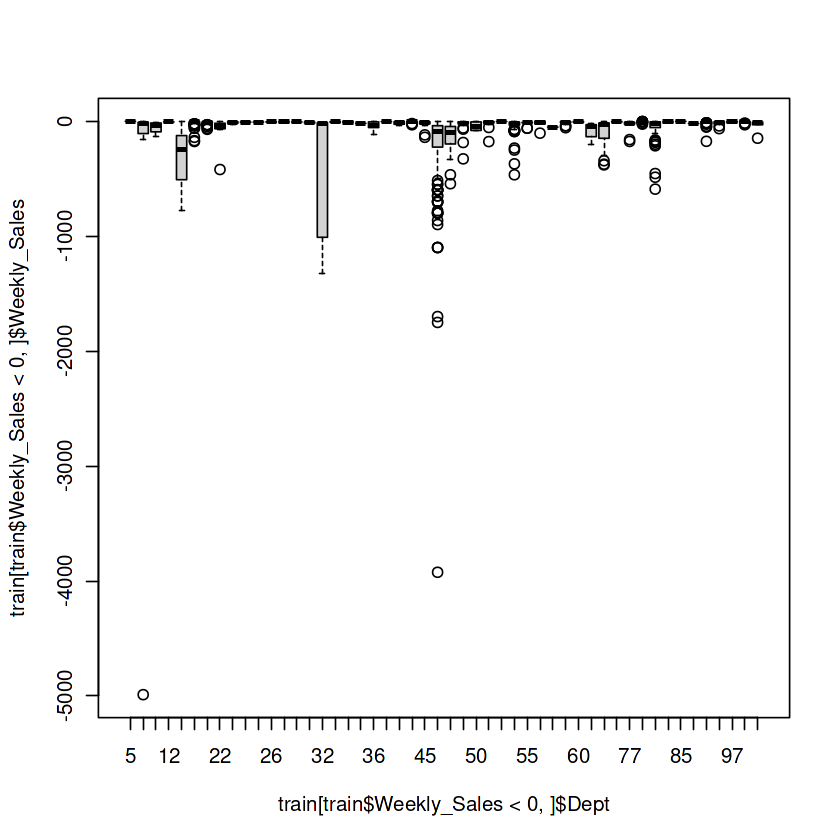

In [5]:
# Create box plot for weekly_sales < 0
boxplot(train[train$Weekly_Sales < 0,]$Weekly_Sales ~ train[train$Weekly_Sales < 0,]$Dept)

The boxplot depicted above reveals the presence of negative values in the **Weekly_Sales** data across multiple departments. The existence of negative values in the sales data suggests potential errors or inconsistencies during the data collection process. To ensure the reliability and accuracy of the data used for forecasting, it is imperative to remove or replace these negative values. Consequently, we will replace any negative values in **Weekly_Sales** variable with zero.

In [6]:
train$Weekly_Sales <- ifelse(train$Weekly_Sales < 0, 0, train$Weekly_Sales)

In addition to examining the sales data, it is crucial to review other datasets. The other dataset may have potential performance to contribute and used as feature engineering can enhance the predictive model's performance and accuracy. Following are summary of the structure of **stores** dataset:

In [7]:
str(stores)

'data.frame':	45 obs. of  3 variables:
 $ Store: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Type : chr  "A" "A" "B" "A" ...
 $ Size : int  151315 202307 37392 205863 34875 202505 70713 155078 125833 126512 ...


The dataset named **stores** contains information such as store ID, type, and size. The **type** attribute categorizes each store based on its size.  As part of my analysis, I generated a boxplot to examine the sizes of the stores, aiming to identify the presence of any outliers.

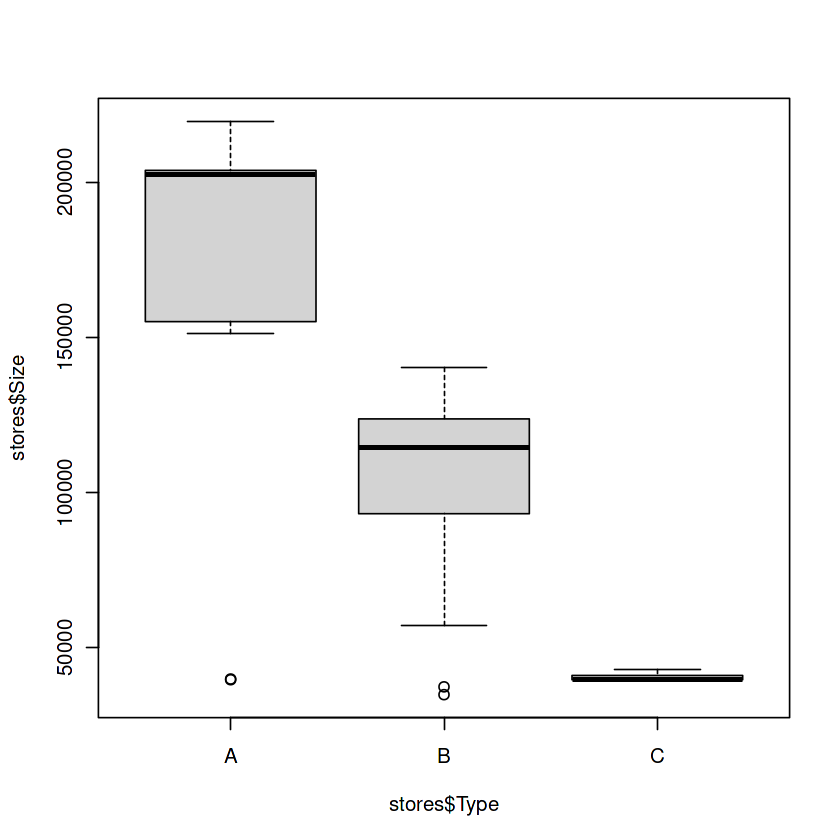

In [8]:
boxplot(stores$Size ~ stores$Type)

It turns out that there are some outliers in store type A and B which deviate from the sizes observed in other stores of the same type. To solving this outlier, we can re-labeling the store type into other type that most relevant with their respective sizes. Following this re-labeling process, a boxplot is presented below, showcasing the updated store type classifications and their corresponding sizes.

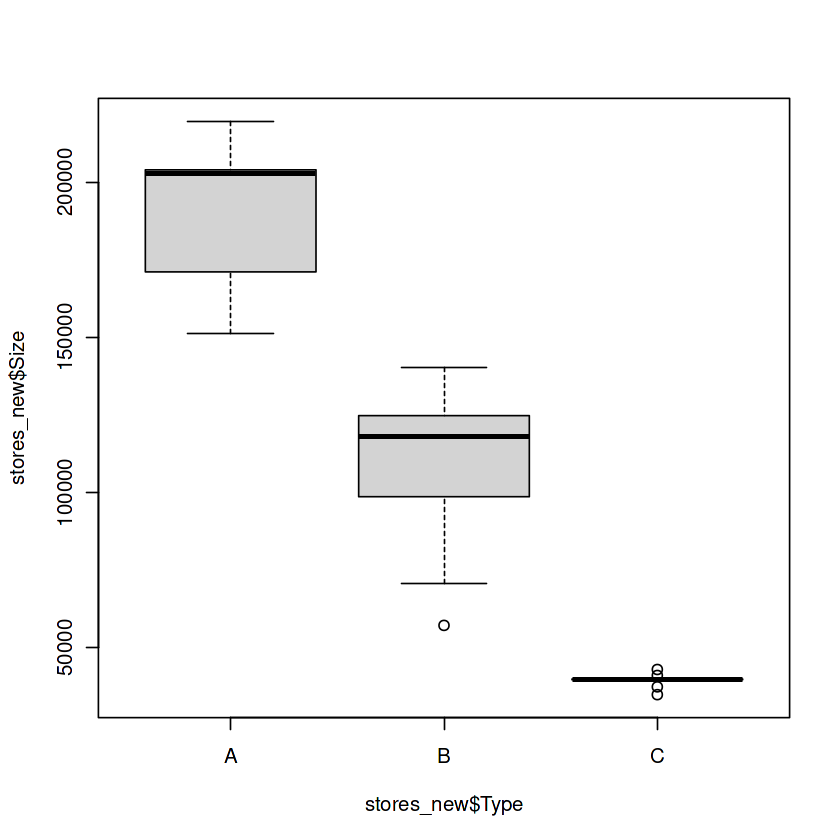

In [9]:
# Find outlier of store type in dataframe Store 
outliers <- stores %>%
  group_by(Type) %>%
  filter(Size < quantile(Size, 0.25) - 1.5 * IQR(Size) | Size > quantile(Size, 0.75) + 1.5 * IQR(Size)) %>%
  ungroup()

# Find mean of each store type (mean without outlier)
stores_without_outliers <- anti_join(stores, outliers, by = "Store")

mean_stores_without_outliers <- stores_without_outliers %>%
  group_by(Type) %>%
  summarise(mean_size = mean(Size))

# re-assign outlier to the nearest store type mean
outliers_newType <- outliers %>% mutate(Type="C")

# create new stores dataframe
stores_new <- rbind(stores_without_outliers,outliers_newType)

boxplot(stores_new$Size ~ stores_new$Type)

Once the assurance of data completeness and cleanliness is obtained, the subsequent step involves creating a time series plot that illustrates the weekly sales.

<a id="section-44"></a>
#### 4.4 Explore timeseries at Store and Dept level

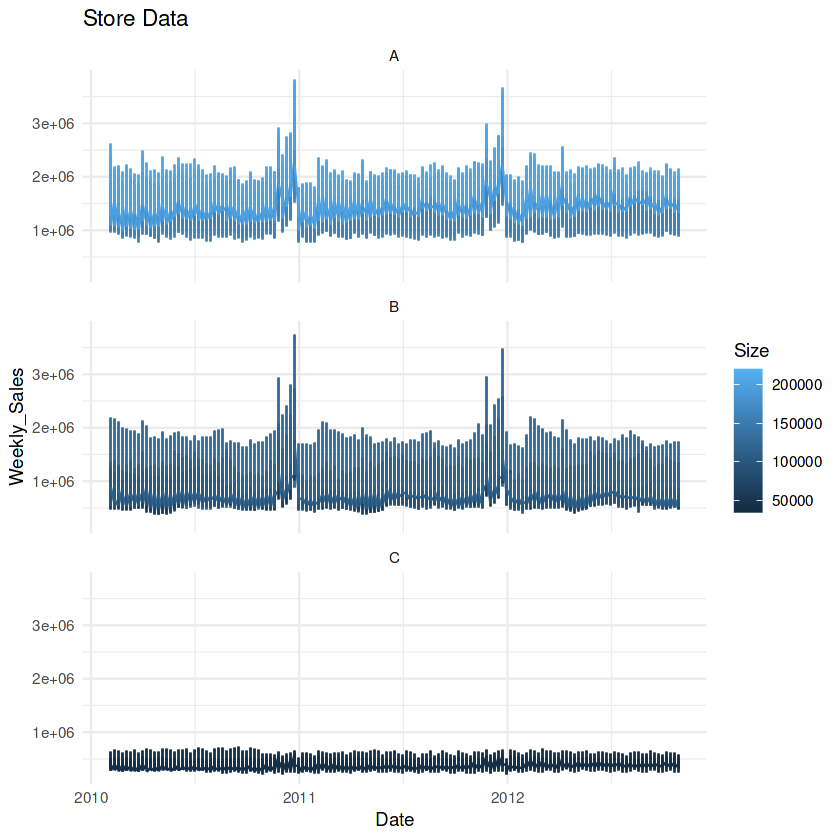

In [10]:
agg_byStore_new <- aggregate(Weekly_Sales ~ Store + Date, data = train, FUN = sum)
agg_byStore_new <- merge(agg_byStore_new, stores_new, by = "Store", all.x = TRUE)

ggplot(agg_byStore_new, aes(x = Date, y = Weekly_Sales, color = Size)) +
  geom_line() +
  labs(x = "Date", y = "Weekly_Sales", title = "Store Data") +
  theme_minimal() +
  facet_wrap(~ Type, nrow = 3)

# Make plots wider 
options(repr.plot.width=50, repr.plot.height=8)

Displayed above is a plot that illustrates the **weekly_sales** for each store type (A, B, C). Observing the plot, it becomes apparent that the data exhibits seasonality. To delve deeper into the analysis, I will generate a weekly sales plot for several departments, providing a more detailed perspective.

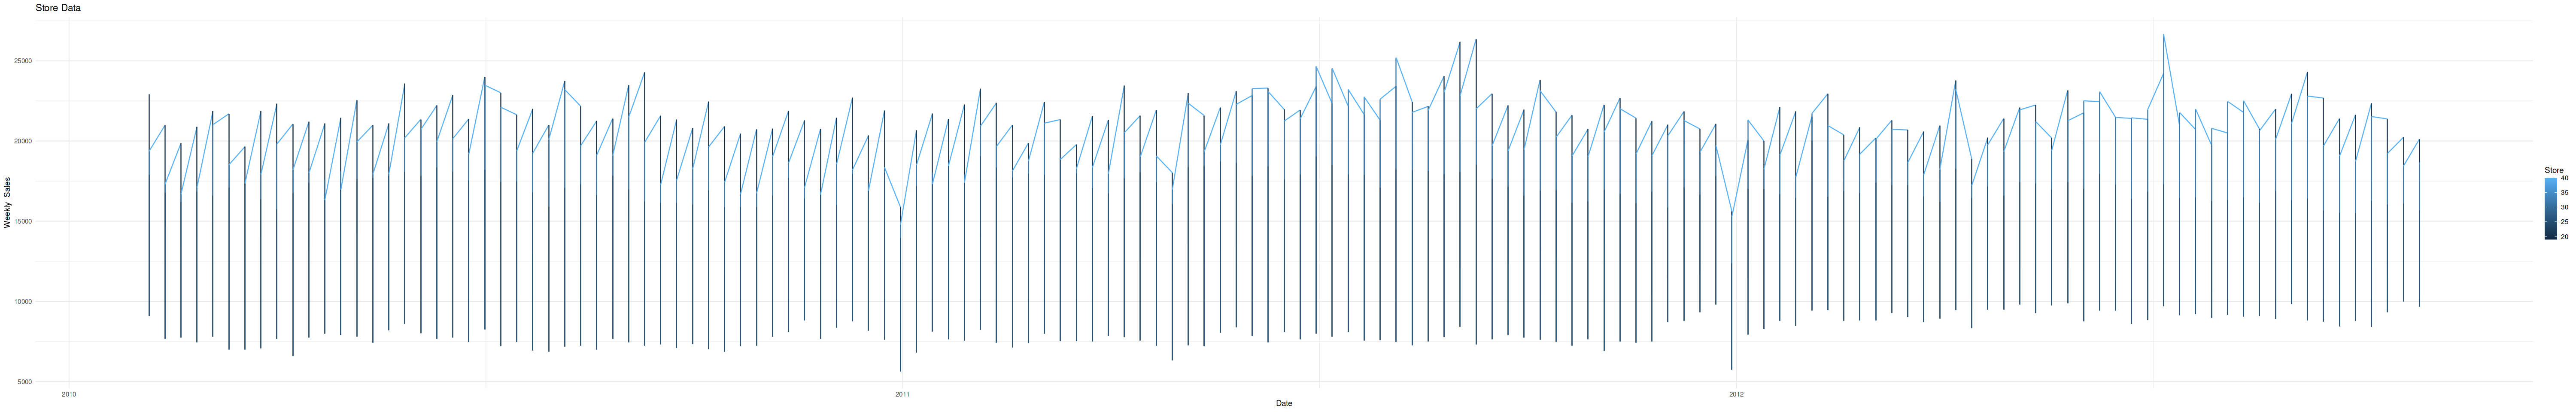

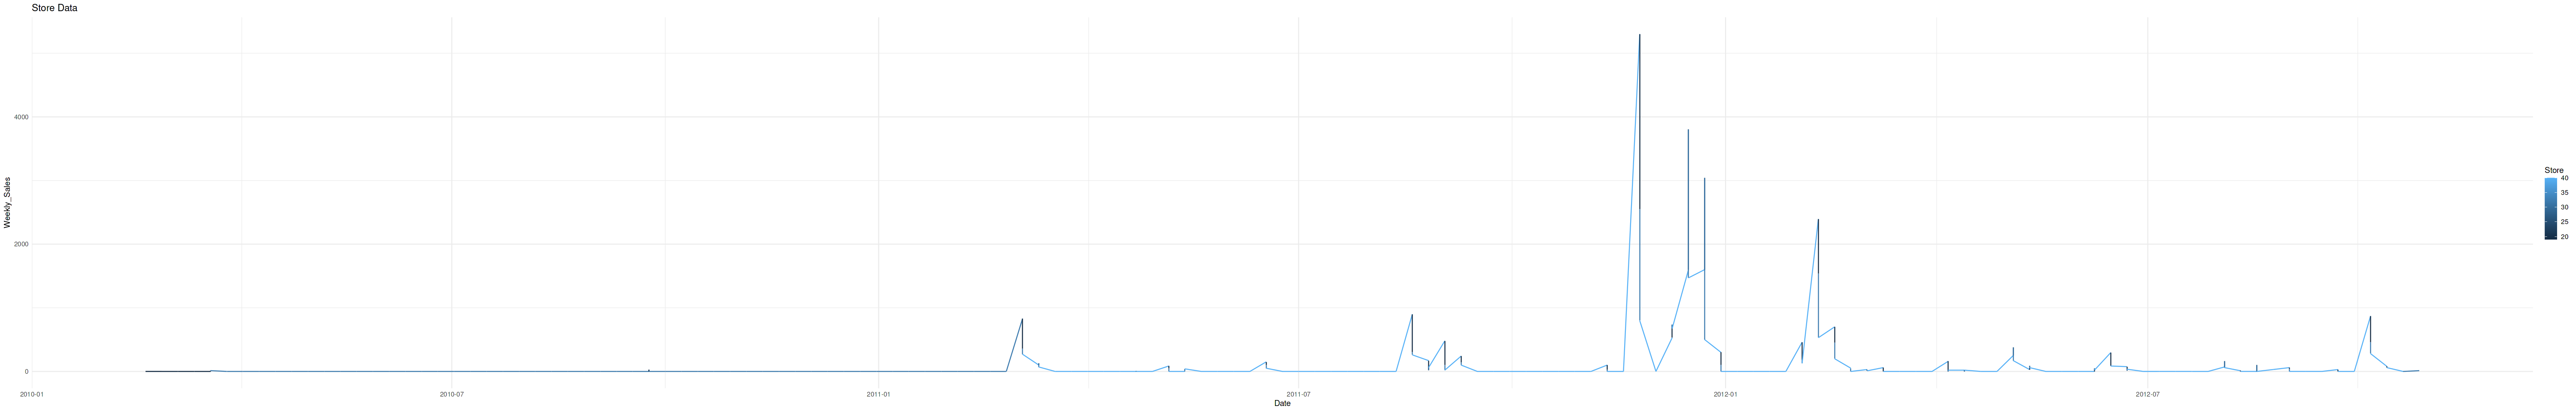

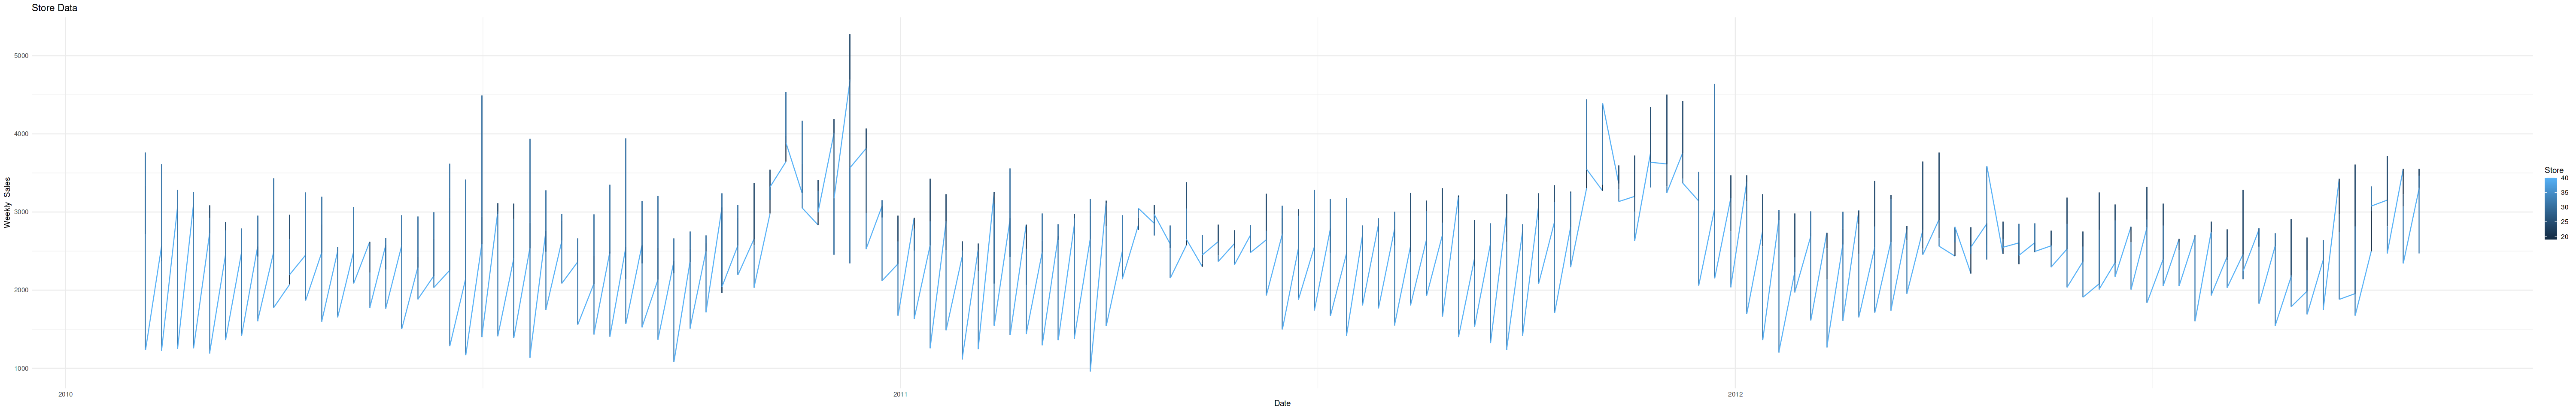

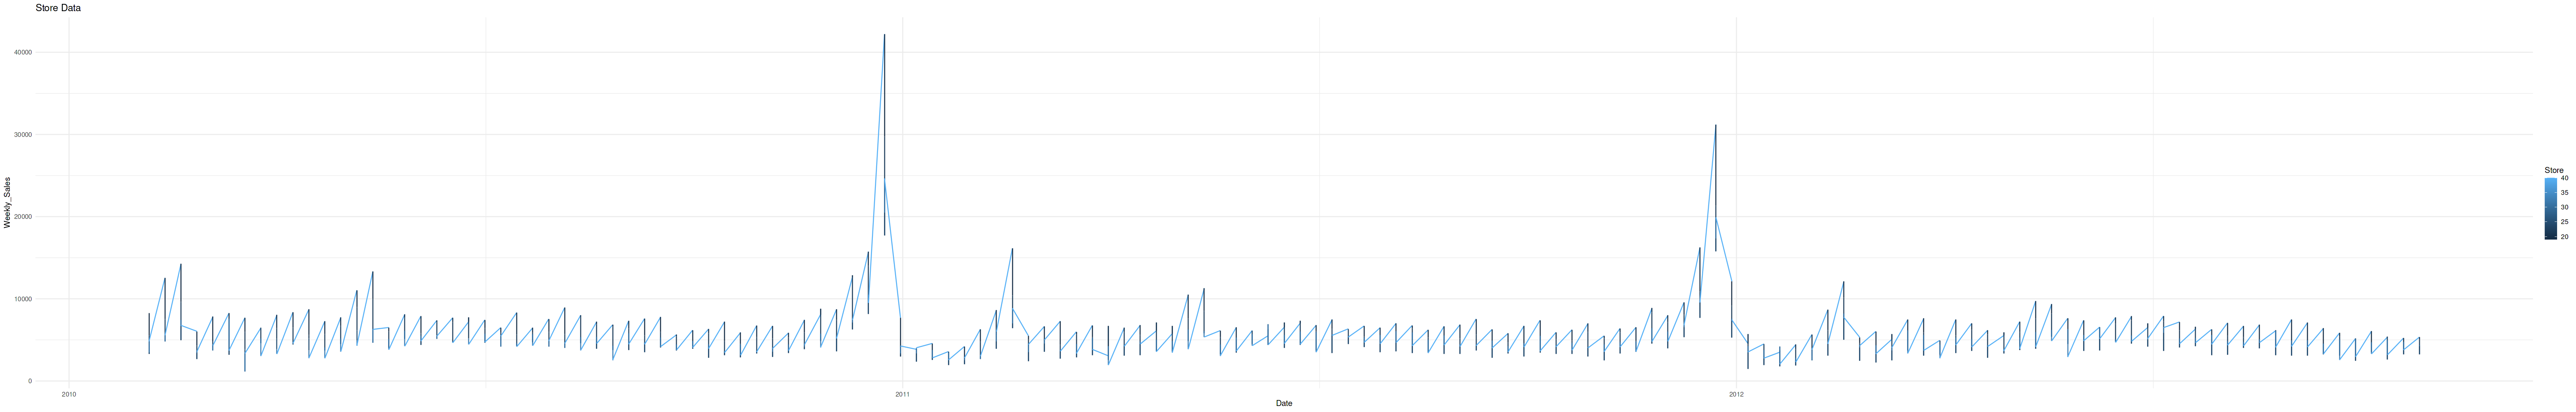

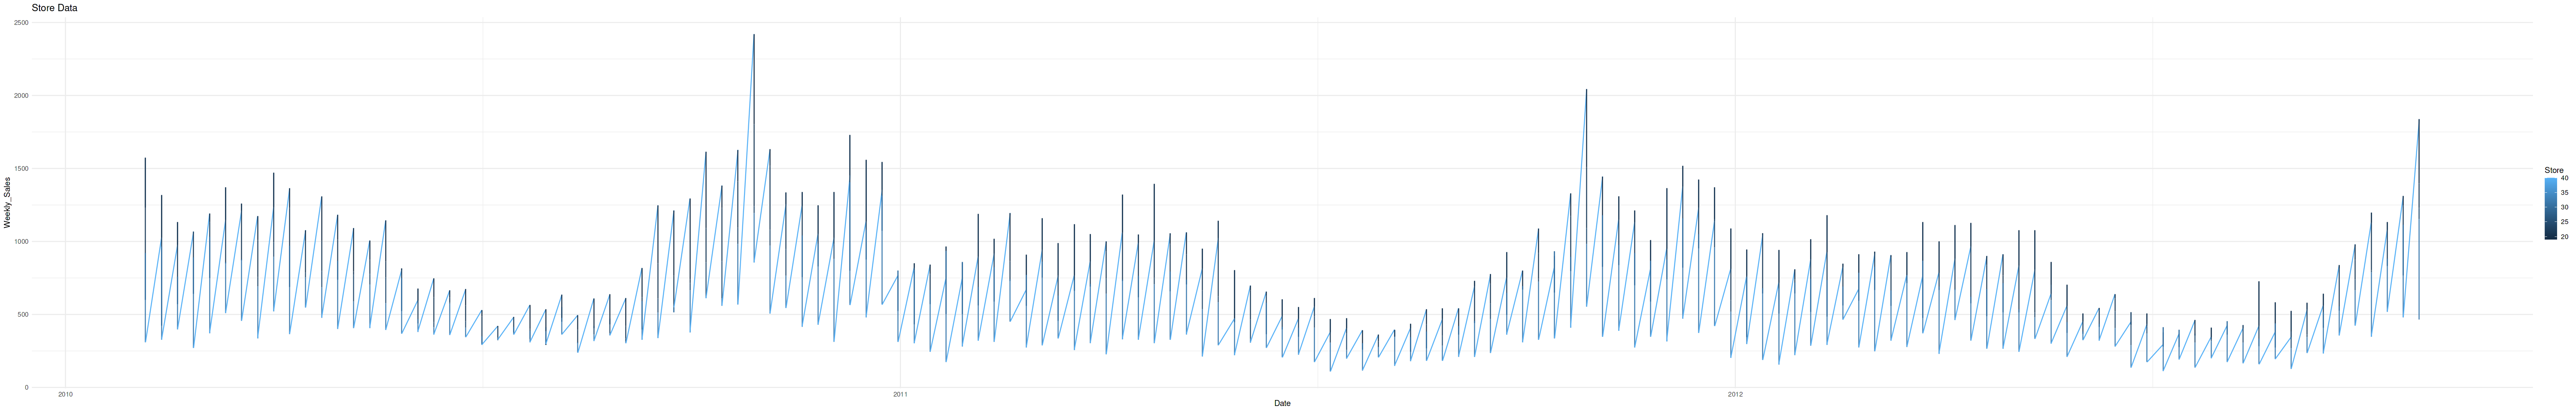

In [11]:
# I will generate plots for a subset of 25 randomly selected time series.
# create list to store 5 random dept, and 5 random store
random_dept = sample(as.list(unique(train$Dept)),5)
random_store = sample(as.list(unique(train$Store)),5)

# do iteration to create time series of 5 Dept with 5 store in it 
for (i in 1:length(random_dept)) {
  # Create a plot for the current category
  plot <- ggplot(train[train$Dept==random_dept[i] & train$Store %in% random_store,], aes(x = Date, y = Weekly_Sales, color=Store)) + 
    geom_line() + 
    labs(x = "Date", y = "Weekly_Sales", title = "Store Data", color="Store") +
    theme_minimal()
    
  # Print the plot
  print(plot)
}

The above plots showcase the time series data for 5 department across in 5 stores. Upon examination, it becomes evident that certain departments exhibit seasonal patterns, while others do not display clear seasonality in their plots. Subsequently, we can proceed with the creation of a machine learning model using the **train** data. Below are the first n-data points from **train** dataset.

<a id="section-5"></a>
#### 5. Build Forecast Model

In [12]:
head(train)

Store,Dept,Date,Weekly_Sales,IsHoliday
<int>,<int>,<date>,<dbl>,<lgl>
1,1,2010-02-05,24924.50,FALSE
1,1,2010-02-12,46039.49,TRUE
1,1,2010-02-19,41595.55,FALSE
1,1,2010-02-26,19403.54,FALSE
1,1,2010-03-05,21827.90,FALSE
1,1,2010-03-12,21043.39,FALSE


It is important to note that we have additional datasets available, **stores** and **features**, which can be used for feature engineering. To incorporate these datasets into the **train** data, we will proceed with merging them.

In [13]:
# merge train data with stores and features
train_all <- train %>% select(-IsHoliday) %>% left_join(stores, by = "Store") %>% left_join(features, by = c("Store","Date"))
head(train_all)

Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
<int>,<int>,<date>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,1,2010-02-05,24924.50,A,151315,42.31,2.572,NA,NA,NA,NA,NA,211.0964,8.106,FALSE
1,1,2010-02-12,46039.49,A,151315,38.51,2.548,NA,NA,NA,NA,NA,211.2422,8.106,TRUE
1,1,2010-02-19,41595.55,A,151315,39.93,2.514,NA,NA,NA,NA,NA,211.2891,8.106,FALSE
1,1,2010-02-26,19403.54,A,151315,46.63,2.561,NA,NA,NA,NA,NA,211.3196,8.106,FALSE
1,1,2010-03-05,21827.90,A,151315,46.50,2.625,NA,NA,NA,NA,NA,211.3501,8.106,FALSE
1,1,2010-03-12,21043.39,A,151315,57.79,2.667,NA,NA,NA,NA,NA,211.3806,8.106,FALSE


After merging the additional datasets into data **train**, it shows that certain columns have a data type of **character**. To facilitate further analysis, we will convert these columns into numerical format, a process referred to as label encoding.

In [14]:
# Perform Label Encoding
train_all$IsHoliday <- as.numeric(factor(train_all$IsHoliday))
train_all$Type <- as.numeric(factor(train_all$Type))

head(train_all)

Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
<int>,<int>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2010-02-05,24924.50,1,151315,42.31,2.572,NA,NA,NA,NA,NA,211.0964,8.106,1
1,1,2010-02-12,46039.49,1,151315,38.51,2.548,NA,NA,NA,NA,NA,211.2422,8.106,2
1,1,2010-02-19,41595.55,1,151315,39.93,2.514,NA,NA,NA,NA,NA,211.2891,8.106,1
1,1,2010-02-26,19403.54,1,151315,46.63,2.561,NA,NA,NA,NA,NA,211.3196,8.106,1
1,1,2010-03-05,21827.90,1,151315,46.50,2.625,NA,NA,NA,NA,NA,211.3501,8.106,1
1,1,2010-03-12,21043.39,1,151315,57.79,2.667,NA,NA,NA,NA,NA,211.3806,8.106,1


<a id="section-51"></a>
#### 5.1 Feature Engineering

In addition to the time series data with weekly sales, we possess additional columns that can be utilized for feature engineering. I have stored these columns in a list called **cols** . **cols**  will be used as feature engineering during forecast model creation.

In [15]:
# Columns with features
cols <- c("IsHoliday","Temperature","Fuel_Price","MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5","CPI","Unemployment")

<a id="section-52"></a>
#### 5.2 Build Forecast Model

We will create and forecast the future weekly_sales on Dept level, hence we will have 3,331 time series (this is the combination of Store and Dept)

In [16]:
# Time series group
store_dept <- distinct(train_all, Store, Dept)
str(store_dept)

tibble [3,331 × 2] (S3: tbl_df/tbl/data.frame)
 $ Store: int [1:3331] 1 1 1 1 1 1 1 1 1 1 ...
 $ Dept : int [1:3331] 1 2 3 4 5 6 7 8 9 10 ...


Subsequently, we iterate through the 3,331 time series at the Dept level to build a forecast model of each time series using LightGBM. LightGBM is a gradient boosting framework that is widely used for machine learning tasks, particularly in the field of predictive modeling.

In [17]:
# Iterate through each time series
for (i in 1:nrow(store_dept)){
    train <- train_all %>%
    filter(Store == store_dept$Store[i] & Dept == store_dept$Dept[i])
    
    # Split data into training and test sets
    train_size <- floor(0.8 * nrow(train))
    train_data <- train[1:train_size, ]
    test_data <- train[(train_size + 1):nrow(train), ]

    Y_train <- train_data$Weekly_Sales
    X_train <- train_data[cols]

    Y_test <- test_data$Weekly_Sales
    X_test <- test_data[cols]
    
    # Define LightGBM parameters
    params <- list(
              objective = "regression",  # Regression objective
              metric = "rmse"  # Evaluation metric: root mean squared error
    )
    
    # Prepare data for LightGBM
    lgbtrain <- lgb.Dataset(data = as.matrix(X_train), label = Y_train, feature_name = cols)
    lgbval <- lgb.Dataset(data = as.matrix(X_test), label = Y_test, reference = lgbtrain, feature_name = cols)

    valids <- list(test = lgbval)

    # Train the LightGBM model
    model <- lgb.train(params = params, data = lgbtrain, valids = valids, num_boost_round = 100,verbose = -1)

    # Make predictions on the test data
    pred <- predict(model, as.matrix(X_test), label = Y_test, feature_name = cols ,num_iteration = model$best_iteration)
    
    # Store the model and predictions
    #store_dept$model[i]<- list(model)
    
    # Calculate Error
    store_dept$mae[i] <- mean(abs(test_data$Weekly_Sales - pred))
    store_dept$rmse[i] <- sqrt(mean((test_data$Weekly_Sales - pred)^2))
    store_dept$mape[i] <- mean(abs((test_data$Weekly_Sales - pred) / test_data$Weekly_Sales)) * 100
}

Warning message:
“Unknown or uninitialised column: `mae`.”
Warning message:
“Unknown or uninitialised column: `rmse`.”
Warning message:
“Unknown or uninitialised column: `mape`.”


<a id="section-53"></a>
#### 5.3 Valid test and measure the error
The error measurement of each model are store in **store_dept** dataframe

In [18]:
head(store_dept)

cat("Overall MAPE :",mean(subset(store_dept, is.finite(mape))$mape),"\n")
cat("Overall MAE :",mean(store_dept$mae),"\n")
cat("Overall RMSE :",mean(store_dept$rmse),"\n")

Store,Dept,mae,rmse,mape
<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,3233.485,4513.491,17.288593
1,2,1875.349,2311.378,4.052063
1,3,6286.741,11051.435,33.845877
1,4,2006.694,2440.372,5.272177
1,5,3295.316,3686.676,17.822302
1,6,1108.730,1381.353,Inf


Overall MAPE : 28.99098 
Overall MAE : 1711.671 
Overall RMSE : 2164.042 


The overal error for 3,331 walmart's time series is 28,9% (MAPE), indicates that on average, the model's predictions have a 28% deviation from the actual values. In other words, the model's forecasted values have an average error rate of 28% relative to the true values. It is important to note that a lower MAPE value indicates better accuracy, so a MAPE of 28% suggests that there is room for improvement in the model's predictive performance.

<a id="section-6"></a>
#### 6. Forecast Future Sales
#### 6.1 Final Model

We will create forecast for Weekly_Sales at 2-11-2012 until 26-07-2013 using best model that already been created in previous section. Follows are the test data set that we'd like to forecast, includes the feature columns :

In [19]:
# Preparing data to forcast weekly sales (2 Nov 12 - 26 Jul 13)
test <- test %>%
  group_by(Store, Dept) %>%
  mutate(Date = as.Date(Date)) %>%
  complete(Date = seq.Date(min(Date), max(Date), by="week")) %>%
  ungroup() %>%
  select(-IsHoliday) %>% left_join(stores, by = "Store") %>% left_join(features, by = c("Store","Date")) %>%
  mutate(IsHoliday = as.numeric(factor(IsHoliday)),Type = as.numeric(factor(Type)))

head(test)

Store,Dept,Date,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
<int>,<int>,<date>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2012-11-02,1,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.4628,6.573,1
1,1,2012-11-09,1,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.4813,6.573,1
1,1,2012-11-16,1,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.5129,6.573,1
1,1,2012-11-23,1,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.5619,6.573,2
1,1,2012-11-30,1,151315,52.34,3.207,2460.03,NA,3838.35,150.57,6966.34,223.6110,6.573,1
1,1,2012-12-07,1,151315,64.12,3.198,6343.16,NA,270.00,2928.90,10147.90,223.6600,6.573,1


We can use all data train to develop the final model. Using all the training data to build the final forecast model ensures that the model learns from as much information as possible. By utilizing the entire dataset, the model can capture the underlying patterns, relationships, and variations present in the data more effectively. The flow on creating final model same as previous section, we store the combination of time series into **store_dept** dataframe then iterate and build the final model through each combination of **store_dept**.

In [20]:
# Time series group
store_dept <- distinct(test, Store, Dept)

pred_df <- data.frame()

# Iterate through each time series
for (i in 1:nrow(store_dept)){
    
    # using all data in train_all
    train_data <- train_all %>%
    filter(Store == store_dept$Store[i] & Dept == store_dept$Dept[i])
    
    #prepare test data
    test_data <- test %>%
    filter(Store == store_dept$Store[i] & Dept == store_dept$Dept[i])
    
    if (nrow(train_data) != 0 && nrow(test_data) != 0) {
            
    Y_train <- train_data$Weekly_Sales
    X_train <- train_data[cols]

    X_test <- test_data[cols]
    
    # Define LightGBM parameters
    params <- list(
              objective = "regression",  # Regression objective
              metric = "rmse"
    )
    
    # Prepare data for LightGBM
    lgbtrain <- lgb.Dataset(data = as.matrix(X_train), label = Y_train, feature_name = cols)

    valids <- list(test = lgbval)

    # Train the LightGBM model
    model <- lgb.train(params = params, data = lgbtrain, num_iterations = 100,verbose = -1)

    # Make predictions on the test data
    pred <- predict(model, as.matrix(X_test),  feature_name = cols)
    test_data$Weekly_Sales <- pred
    
    pred_df <- rbind(pred_df,test_data)
    }
    
}

<a id="section-62"></a>
#### 6.2 Submitted Forecast
the predictions of 2-11-2012 - 26-07-2013 **weekly_sales** are store into **pred_df** dataframe

In [21]:
head(pred_df)
str(pred_df)

Store,Dept,Date,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
<int>,<int>,<date>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2012-11-02,1,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.4628,6.573,1,27473.24
1,1,2012-11-09,1,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.4813,6.573,1,24558.88
1,1,2012-11-16,1,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.5129,6.573,1,30146.09
1,1,2012-11-23,1,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.5619,6.573,2,25234.65
1,1,2012-11-30,1,151315,52.34,3.207,2460.03,NA,3838.35,150.57,6966.34,223.6110,6.573,1,28582.97
1,1,2012-12-07,1,151315,64.12,3.198,6343.16,NA,270.00,2928.90,10147.90,223.6600,6.573,1,18232.16


tibble [118,588 × 16] (S3: tbl_df/tbl/data.frame)
 $ Store       : int [1:118588] 1 1 1 1 1 1 1 1 1 1 ...
 $ Dept        : int [1:118588] 1 1 1 1 1 1 1 1 1 1 ...
 $ Date        : Date[1:118588], format: "2012-11-02" "2012-11-09" ...
 $ Type        : num [1:118588] 1 1 1 1 1 1 1 1 1 1 ...
 $ Size        : int [1:118588] 151315 151315 151315 151315 151315 151315 151315 151315 151315 151315 ...
 $ Temperature : num [1:118588] 55.3 61.2 52.9 56.2 52.3 ...
 $ Fuel_Price  : num [1:118588] 3.39 3.31 3.25 3.21 3.21 ...
 $ MarkDown1   : num [1:118588] 6766 11421 9696 884 2460 ...
 $ MarkDown2   : num [1:118588] 5147.7 3370.89 292.1 4.17 NA ...
 $ MarkDown3   : num [1:118588] 50.8 40.3 103.8 74910.3 3838.3 ...
 $ MarkDown4   : num [1:118588] 3640 4647 1133 210 151 ...
 $ MarkDown5   : num [1:118588] 2737 6154 6613 303 6966 ...
 $ CPI         : num [1:118588] 223 223 224 224 224 ...
 $ Unemployment: num [1:118588] 6.57 6.57 6.57 6.57 6.57 ...
 $ IsHoliday   : num [1:118588] 1 1 1 2 1 1 1 1 2 1 ..

let's store the predictions into **final_pred.csv**

In [22]:
write.csv(pred_df, file = "final_pred.csv", row.names = FALSE)